In [93]:
import opendatasets as od
import numpy as np
import pandas as pd
import unidecode 
import nltk
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
import re 
import time
from nltk.corpus import stopwords 
from nltk import word_tokenize 
import string 
import joblib
import logging
import gensim.downloader
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from wordcloud import WordCloud
from tqdm import tqdm
pd.set_option('display.max_columns', 40)
from bs4 import BeautifulSoup 
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.cluster import AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC,SVC
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.model_selection import train_test_split


In [2]:
pwd

'/Users/crazyk'

In [3]:
#API Credentials
user = "karan7865"
key =  "13ab66c6d07233692931b21e96d616ba"

In [4]:
#When you use this it will ask to download the dataset and add your credentials.
od.download("https://www.kaggle.com/datasets/visalakshiiyer/twitter-data-brexit"
           )

Skipping, found downloaded files in "./twitter-data-brexit" (use force=True to force download)


In [5]:
stop=set(stopwords.words('english'))

# DATA DESCRIPTION

Date: The date the tweet was posted to Twitter.

URL: link to the tweet.

Hit Sentence: Tweet text.

Influencer: Account name for the user who shared the tweet.

Country: Country location of the Twitter account (if declared).

Subregion: Locale of the Twitter account (if declared).

Language: Automated language detection.

Reach: Estimate of the “reach” of the tweet, based on followers at the time of sending tweet.

Engagement: Sum of public engagements for the tweet (sum of likes, retweets and quote tweets).

Twitter Screen Name: Displayed	name as appears on the Twitter profile of account.

User Profile Url: URL link to the Twitter account that shared the tweet.

Twitter Bio: Text from the Twitter bio section of the account.

Twitter Followers: Number of followers of the account.

Twitter Following: Number of accounts that are followed by this account.

Alternate Date Format: The date the tweet was posted to Twitter.

Time: The time the tweet was posted to.

In [6]:
#LOADING DATA
df_anti = pd.read_csv("twitter-data-brexit/TweetDataset_AntiBrexit_Jan-Mar2022.csv")
df_pro = pd.read_csv("twitter-data-brexit/TweetDataset_ProBrexit_Jan-Mar2022.csv")

In [7]:
df_anti['target'] = "anti"
df_pro['target'] = "pro"

In [8]:
#Merging datasets
df_full = df_pro.append(df_anti)

In [9]:
df_full[['Hit Sentence','target']].head()

,Hit Sentence,target
0,RT @re11ddy: QT @sandieshoes: Do this if you v...,pro
1,RT @RickSacrop: Michael Fabricant is absolutel...,pro
2,@StokieDrew2 I do find it rich; that Tory vote...,pro
3,RT @denistmurray: Brexit Britain win as London...,pro
4,@afneil If Johnson is taken down by The Tories...,pro


In [10]:
df_full.to_csv("Raw_data.csv",index=False)

In [11]:
print(len(df_full.columns))

39


# Analysis

- Check the unique values in the dataset, if the percentage of unique values in a column is 99% drop that.
- Check if there are 0 or 1 unique value in the dataset, since if all values are same again not really important for us.
- Check null values in the dataset if there are more that 98% nulls remove that column.

In [12]:
#Percentage of unique values in a column
df_full.nunique()/df_full.shape[0]

Unnamed: 0               0.054938
Date                     0.289616
Headline                 0.000000
URL                      0.997566
Opening Text             0.000000
Hit Sentence             0.537382
Source                   0.000003
Influencer               0.018489
Country                  0.000151
Subregion                0.000000
Language                 0.000114
Reach                    0.055061
Desktop Reach            0.000003
Mobile Reach             0.000003
Twitter Social Echo      0.000000
Facebook Social Echo     0.000000
Reddit Social Echo       0.000000
National Viewership      0.000003
Engagement               0.002764
AVE                      0.051984
Sentiment                0.000011
Key Phrases              0.370238
Input Name               0.000003
Keywords                 0.015862
Twitter Authority        0.000028
Tweet Id                 0.997566
Twitter Id               0.012540
Twitter Client           0.000078
Twitter Screen Name      0.015114
User Profile U

In [13]:
#Percentage of nulls
df_full.isnull().sum()/df_full.shape[0]

Unnamed: 0               0.000000
Date                     0.000000
Headline                 1.000000
URL                      0.000000
Opening Text             1.000000
Hit Sentence             0.000000
Source                   0.000000
Influencer               0.000000
Country                  0.000000
Subregion                1.000000
Language                 0.000000
Reach                    0.000000
Desktop Reach            0.000000
Mobile Reach             0.000000
Twitter Social Echo      1.000000
Facebook Social Echo     1.000000
Reddit Social Echo       1.000000
National Viewership      0.000000
Engagement               0.928413
AVE                      0.000000
Sentiment                0.000000
Key Phrases              0.126196
Input Name               0.000000
Keywords                 0.000000
Twitter Authority        0.000664
Tweet Id                 0.000000
Twitter Id               0.000000
Twitter Client           0.000000
Twitter Screen Name      0.000000
User Profile U

In [14]:
#removing columns with 1 or < 1 unique values
for i in df_full.columns:
    if df_full[i].nunique() <= 1:
        df_full.drop(i,axis=1,inplace=True)

In [15]:
#Only 27 Columns remain
len(df_full.columns)

27

In [16]:
df_full.dtypes

Unnamed: 0                 int64
Date                      object
URL                       object
Hit Sentence              object
Influencer                object
Country                   object
Language                  object
Reach                      int64
Engagement               float64
AVE                      float64
Sentiment                 object
Key Phrases               object
Keywords                  object
Twitter Authority        float64
Tweet Id                  object
Twitter Id                 int64
Twitter Client            object
Twitter Screen Name       object
User Profile Url          object
Twitter Bio               object
Twitter Followers        float64
Twitter Following        float64
Alternate Date Format     object
Time                      object
State                     object
City                      object
target                    object
dtype: object

In [17]:
df_full.head()

,Unnamed: 0,Date,URL,Hit Sentence,Influencer,Country,Language,Reach,Engagement,AVE,Sentiment,Key Phrases,Keywords,Twitter Authority,Tweet Id,Twitter Id,Twitter Client,Twitter Screen Name,User Profile Url,Twitter Bio,Twitter Followers,Twitter Following,Alternate Date Format,Time,State,City,target
0,0,15-Jan-2022 11:58PM,https://twitter.com/dianemcgregor8/statuses/14...,RT @re11ddy: QT @sandieshoes: Do this if you v...,@dianemcgregor8,Cameroon,English,122,NaN,1.13,Neutral,NaN,Brexit,4.0,'1482502364728893442',2333154780,Twitter for Android,Diane M McGregor,https://twitter.com/dianemcgregor8,Veggie burger! Lover of all Animals and Nature...,122.0,185.0,"Jan 15, 2022",11:58 PM,North,NaN,pro
1,1,15-Jan-2022 11:57PM,http://twitter.com/DeniseMembery/statuses/1482...,RT @RickSacrop: Michael Fabricant is absolutel...,@DeniseMembery,United Kingdom,English,5721,NaN,52.92,Negative,"hell bent,precious EU",EU,7.0,'1482502266603118599',3678878175,Twitter for Android,Denise M.,http://www.twitter.com/DeniseMembery,"🇬🇧✡️ Proud to be British. 🇬🇧 Animal lover, m...",5721.0,6291.0,"Jan 15, 2022",11:57 PM,England,NaN,pro
2,2,15-Jan-2022 11:56PM,https://twitter.com/007Stirling/statuses/14825...,@StokieDrew2 I do find it rich; that Tory vote...,@007stirling,United Kingdom,English,7219,NaN,66.78,Negative,"Johnson leadership,Tory voters","Brexit,EU",7.0,'1482501928479301632',1384540273494069249,Twitter for Android,Finlay Stirling 🇬🇧☘️❤️🏴󠁧󠁢󠁳󠁣󠁴󠁿,https://twitter.com/007Stirling,BRITISH/IRISH/ULSTER-SCOTS PUL\nRIGHT-WING. \n...,7219.0,7433.0,"Jan 15, 2022",11:56 PM,Northern Ireland,Belfast,pro
3,3,15-Jan-2022 11:54PM,https://twitter.com/UKleadstheworld/statuses/1...,RT @denistmurray: Brexit Britain win as London...,@ukleadstheworld,United Kingdom,English,700,NaN,6.48,Positive,best city,Brexit,5.0,'1482501439624732672',1394212805071577089,Twitter for iPhone,BestofBritish,https://twitter.com/UKleadstheworld,"GB News, Conservatives, Brexiteer, Block all ads.",700.0,1014.0,"Jan 15, 2022",11:54 PM,NaN,NaN,pro
4,4,15-Jan-2022 11:53PM,https://twitter.com/paul_beamish/statuses/1482...,@afneil If Johnson is taken down by The Tories...,@paul_beamish,United Kingdom,English,200,NaN,1.85,Neutral,"credible Brexiteer,droves,likelihood","Brexiteers,Brexiteer",4.0,'1482501195767898119',971698786148986880,Twitter for Android,Paul Beamish,https://twitter.com/paul_beamish,Brexiteer and Shipbuilder (Plater/Welder) livi...,200.0,822.0,"Jan 15, 2022",11:53 PM,England,NaN,pro


**Some Observations**

- Unamed : 0 seems to be like a redundant column with just the index, so we can just remove it.
- Engagement is a column with 92% null values need to analyse more to see if its useful or not.

**Preprocessing Text data**

- Since this data was extracted from twitter, there are columns like Hit Sentence and Twitter Bio which are free text columns.
- These need to be pre processed to do some analysis.
- Some preprocessing include 
    - All Lowercase.
    - Replacing the \n or \\n with a white space.
    - Stripping Html tags.
    - removing links.
    - Removing extra whitespaces.
    - Removing unicode characters.
    - Stemming.
    - Lemmatization.
    - Removing special characters and numbers.
    - Adding a contraction map i.e converting can't to can not.
    - Removing stop words
    - Removing words with len < 2.

In [18]:
def text_preprocessing(text,cont_map):
    # Replacing all the occurrences of \n,\\n,\t,\\ with a space.
    text = text.lower()
    text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ').replace('. com', '.com')
    #strip html tags
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    #remove links
    stripped_text = re.sub(r'http\S+', '', stripped_text)
    stripped_text = re.sub(r"\ [A-Za-z]*\.com", " ", stripped_text)
    #remove whitespace
    pattern = re.compile(r'\s+') 
    no_whitespace = re.sub(pattern, ' ', stripped_text)
    stripped_text = no_whitespace.replace('?', ' ? ').replace(')', ') ')
    #Removing unicode characters
    stripped_text = unidecode.unidecode(stripped_text)
    #Changing words like cherrrrrrrry to cherry
    pattern_alpha= re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)
    stripped_text = pattern_alpha.sub(r"\1\1", stripped_text) 
    pattern_punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')
    stripped_text = pattern_punct.sub(r'\1', stripped_text)
    stripped_text = re.sub(' {2,}',' ', stripped_text)
    
    tokens = stripped_text.split(' ')
    for word in tokens: 
         if word in cont_map: 
                tokens = [item.replace(word, cont_map[word]) for item in tokens]
                
    text = ' '.join(str(e) for e in tokens) 
    #removing special characters and numbers
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = re.sub(r"[^a-zA-Z:$-,%.?!]+", ' ', text)
    #removing words with len <= 2.
    text = re.sub(r'\b\w{1,2}\b', '', text)
    #lemmatization swimming , swim
    text = [lemmatizer.lemmatize(w,'v') for w in w_tokenizer.tokenize(text)]
    #removing stopwords
    text = ' '.join([word for word in text if word not in stop])
    return text

In [19]:
#map with mapping of words like can't: can not.
cont_map = joblib.load("twitter-data-brexit/contraction_map.pkl")
#the lemmetizer library from nltk.
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

In [20]:
#Preprocessing
cleaned_text = []
for i in tqdm(df_full['Twitter Bio']):
    cleaned_text.append(text_preprocessing(i,cont_map))
df_full['Twitter Bio'] = cleaned_text

cleaned_text = []
for i in tqdm(df_full['Hit Sentence']):
    cleaned_text.append(text_preprocessing(i,cont_map))
df_full['Hit Sentence'] = cleaned_text

100%|█████████████████████████████████| 358205/358205 [01:29<00:00, 4005.54it/s]


In [21]:
df_full['len_twitter_bio'] = df_full['Twitter Bio'].apply(lambda x: len(x.split()))
df_full['len_hit_sent'] = df_full['Hit Sentence'].apply(lambda x: len(x.split()))

**Here we will analyse tweets by people who are anti brexit and people who are pro brexit separately to 
check how these groups tweet like is there any similarity.**

**TEXT ANALYSIS**

- Wordcloud will tell us what are the most common words used by both the groups.
- Length of text will help us to tell how long these sentences are written by these groups.
- No of words in a sentence.
- Avg word length in a sentence.
- Top 20 words used by both the groups.
- Top 10 bigrams used by both the groups.
- Top 10 trigrams used by both groups.

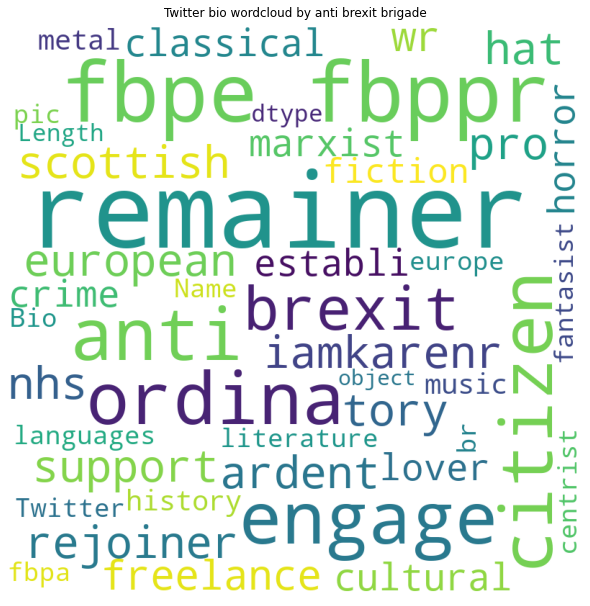

In [22]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white').generate(str(df_full[df_full['target'] == 'anti']['Twitter Bio']))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Twitter bio wordcloud by anti brexit brigade")
plt.show()

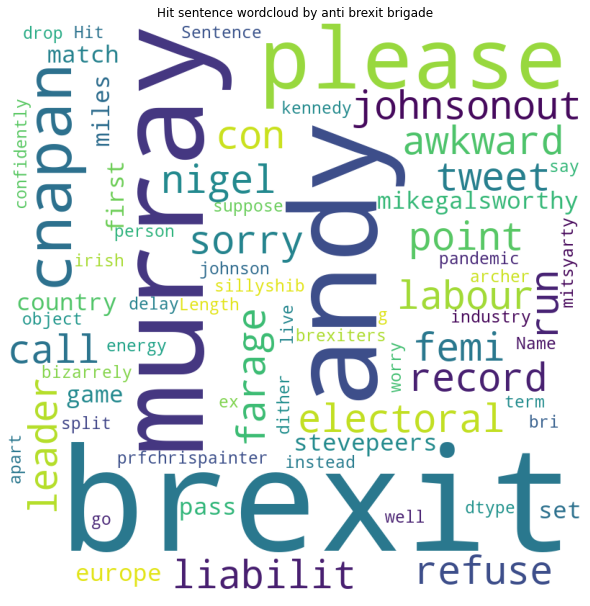

In [23]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white').generate(str(df_full[df_full['target'] == 'anti']['Hit Sentence']))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Hit sentence wordcloud by anti brexit brigade")
plt.show()

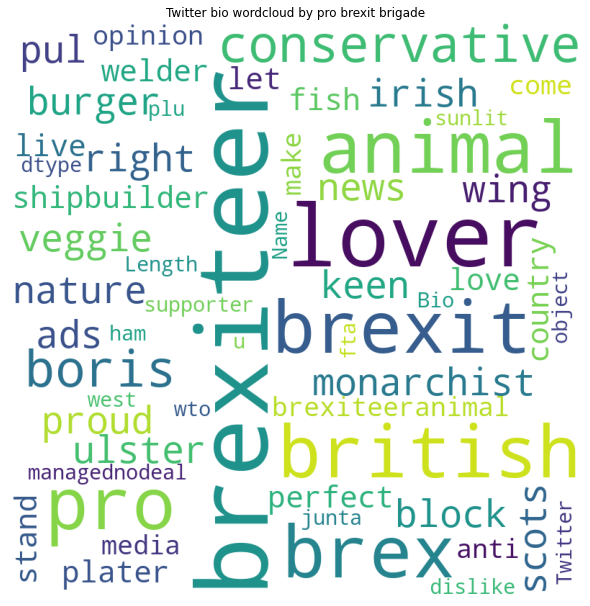

In [24]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white').generate(str(df_full[df_full['target'] == 'pro']['Twitter Bio']))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Twitter bio wordcloud by pro brexit brigade")
plt.show()

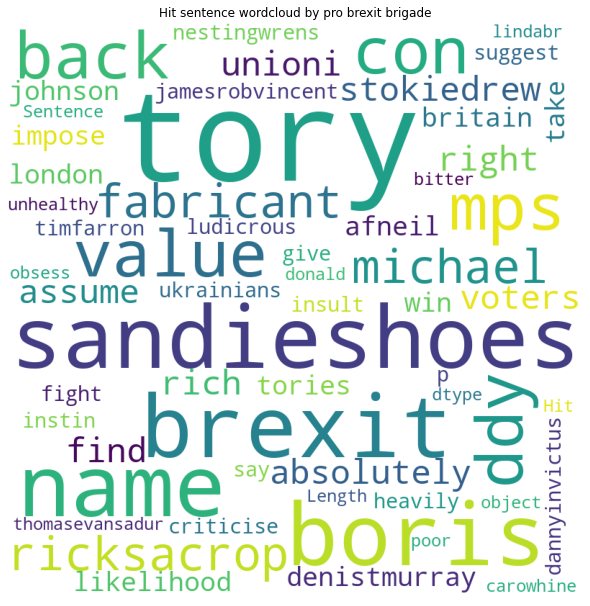

In [25]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white').generate(str(df_full[df_full['target'] == 'pro']['Hit Sentence']))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Hit sentence wordcloud by pro brexit brigade")
plt.show()

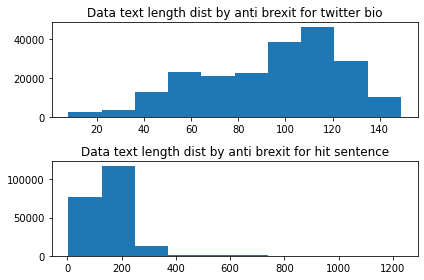

In [26]:
fig, (ax1, ax2) = plt.subplots(2)

ax1.hist(df_full[df_full['target'] == 'anti']['Twitter Bio'].str.len())
ax1.set_title("Data text length dist by anti brexit for twitter bio")

ax2.hist(df_full[df_full['target'] == 'anti']['Hit Sentence'].str.len())
ax2.set_title("Data text length dist by anti brexit for hit sentence")

fig.tight_layout()

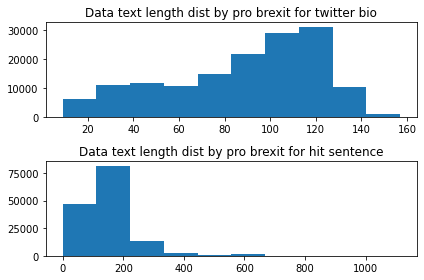

In [27]:
fig, (ax1, ax2) = plt.subplots(2)

ax1.hist(df_full[df_full['target'] == 'pro']['Twitter Bio'].str.len())
ax1.set_title("Data text length dist by pro brexit for twitter bio")

ax2.hist(df_full[df_full['target'] == 'pro']['Hit Sentence'].str.len())
ax2.set_title("Data text length dist by pro brexit for hit sentence")

fig.tight_layout()

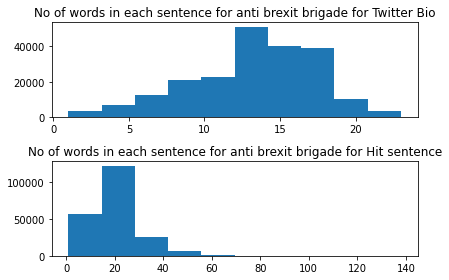

In [28]:
#Number of words in each sentence
fig, (ax1, ax2) = plt.subplots(2)

ax1.hist(df_full[df_full['target'] == 'anti']['Twitter Bio'].str.split().map(lambda x: len(x)))
ax1.set_title("No of words in each sentence for anti brexit brigade for Twitter Bio")

ax2.hist(df_full[df_full['target'] == 'anti']['Hit Sentence'].str.split().map(lambda x: len(x)))
ax2.set_title("No of words in each sentence for anti brexit brigade for Hit sentence")

fig.tight_layout()

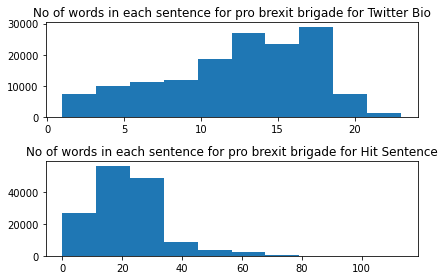

In [29]:
fig, (ax1, ax2) = plt.subplots(2)

ax1.hist(df_full[df_full['target'] == 'pro']['Twitter Bio'].str.split().map(lambda x: len(x)))
ax1.set_title("No of words in each sentence for pro brexit brigade for Twitter Bio")

ax2.hist(df_full[df_full['target'] == 'pro']['Hit Sentence'].str.split().map(lambda x: len(x)))
ax2.set_title("No of words in each sentence for pro brexit brigade for Hit Sentence")

fig.tight_layout()

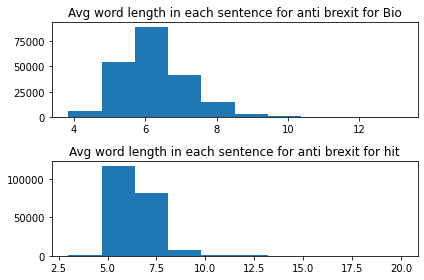

In [30]:
#Avg word length
fig, (ax1, ax2) = plt.subplots(2)

ax1.hist(df_full[df_full['target'] == 'anti']['Twitter Bio'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)))
ax1.set_title("Avg word length in each sentence for anti brexit for Bio")

ax2.hist(df_full[df_full['target'] == 'anti']['Hit Sentence'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)))
ax2.set_title("Avg word length in each sentence for anti brexit for hit")

fig.tight_layout()

/Users/crazyk/opt/anaconda3/envs/test/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/crazyk/opt/anaconda3/envs/test/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


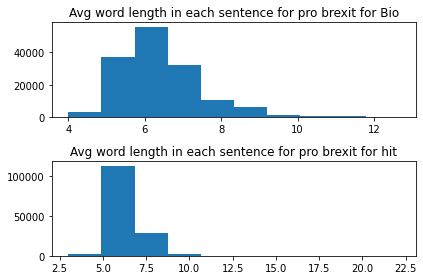

In [31]:
fig, (ax1, ax2) = plt.subplots(2)

ax1.hist(df_full[df_full['target'] == 'pro']['Twitter Bio'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)))
ax1.set_title("Avg word length in each sentence for pro brexit for Bio")

ax2.hist(df_full[df_full['target'] == 'pro']['Hit Sentence'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)))
ax2.set_title("Avg word length in each sentence for pro brexit for hit")

fig.tight_layout()

In [32]:
#Top words used by both groups
def plot_top_words(text):
    stop=set(stopwords.words('english'))
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    corpus = [word for word in corpus if word not in stop]
    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:20]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    return (x,y)

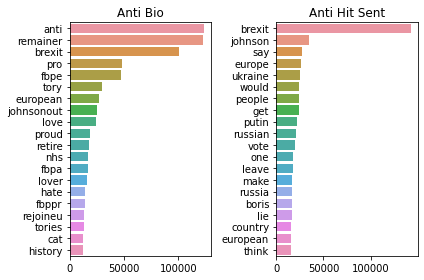

In [33]:
fig, (ax1, ax2) =  plt.subplots(1,2)

x,y = plot_top_words(df_full[df_full['target'] == 'anti']['Twitter Bio'])
sns.barplot(x = y,y = x,ax=ax1).set_title("Anti Bio")

x,y = plot_top_words(df_full[df_full['target'] == 'anti']['Hit Sentence'])
sns.barplot(x = y,y = x,ax=ax2).set_title("Anti Hit Sent")

fig.tight_layout()

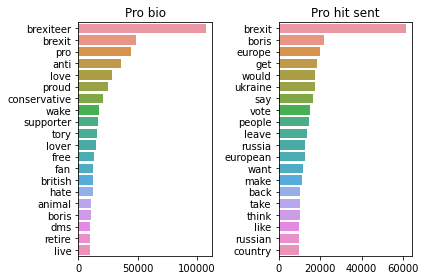

In [34]:
fig, (ax1, ax2) =  plt.subplots(1,2)

x,y = plot_top_words(df_full[df_full['target'] == 'pro']['Twitter Bio'])
sns.barplot(x = y,y = x,ax=ax1).set_title("Pro bio")

x,y = plot_top_words(df_full[df_full['target'] == 'pro']['Hit Sentence'])
sns.barplot(x = y,y = x,ax=ax2).set_title("Pro hit sent")

fig.tight_layout()

In [35]:
#Plot N-grams
def plot_top_ngrams(text, n=2):
    stop=set(stopwords.words('english'))
    new= text.str.split('\n')
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    corpus =[word for word in corpus if word not in stop]
    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(token_pattern=r"(?u)\b\w+\b",ngram_range=(n, n),stop_words=None,analyzer='word').fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(corpus,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    
    return (x,y)

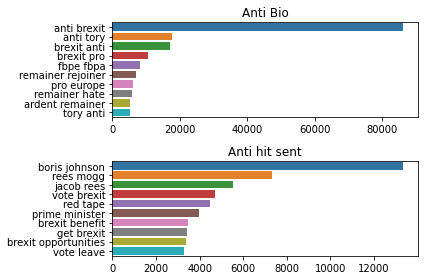

In [36]:
#Bigrams
fig, (ax1, ax2) =  plt.subplots(2)

x,y = plot_top_ngrams(df_full[df_full['target'] == 'anti']['Twitter Bio'])
sns.barplot(x = y,y = x,ax=ax1).set_title("Anti Bio")

x,y = plot_top_ngrams(df_full[df_full['target'] == 'anti']['Hit Sentence'])
sns.barplot(x = y,y = x,ax=ax2).set_title("Anti hit sent")

fig.tight_layout()

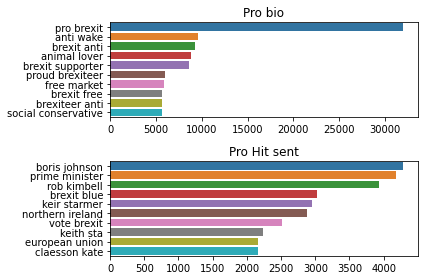

In [37]:
fig, (ax1, ax2) =  plt.subplots(2)

x,y = plot_top_ngrams(df_full[df_full['target'] == 'pro']['Twitter Bio'])
sns.barplot(x = y,y = x,ax=ax1).set_title("Pro bio")

x,y = plot_top_ngrams(df_full[df_full['target'] == 'pro']['Hit Sentence'])
sns.barplot(x = y,y = x,ax=ax2).set_title("Pro Hit sent")

fig.tight_layout()

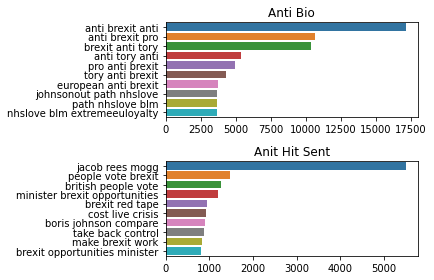

In [38]:
#Trigrams
fig, (ax1, ax2) =  plt.subplots(2)

x,y = plot_top_ngrams(df_full[df_full['target'] == 'anti']['Twitter Bio'],n=3)
sns.barplot(x = y,y = x,ax=ax1).set_title("Anti Bio")

x,y = plot_top_ngrams(df_full[df_full['target'] == 'anti']['Hit Sentence'],n=3)
sns.barplot(x = y,y = x,ax=ax2).set_title("Anit Hit Sent")

fig.tight_layout()

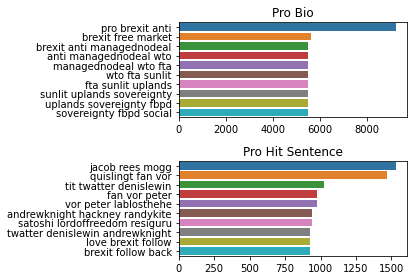

In [39]:
fig, (ax1, ax2) =  plt.subplots(2)

x,y = plot_top_ngrams(df_full[df_full['target'] == 'pro']['Twitter Bio'],n=3)
sns.barplot(x = y,y = x,ax=ax1).set_title("Pro Bio")

x,y = plot_top_ngrams(df_full[df_full['target'] == 'pro']['Hit Sentence'],n=3)
sns.barplot(x = y,y = x,ax=ax2).set_title("Pro Hit Sentence")

fig.tight_layout()

**Some Analyses of other columns we have**

- Check how many tweets are done by Anti and Pro Brigades.
- Check the distributions of columns that are numeric.
- Check the correlation plots.

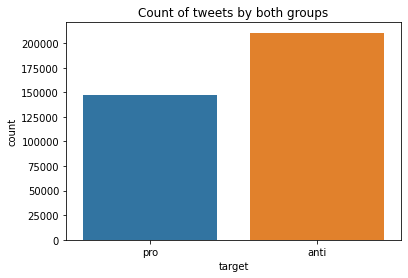

In [40]:
sns.countplot(data=df_full,x='target').set_title("Count of tweets by both groups")
plt.show()

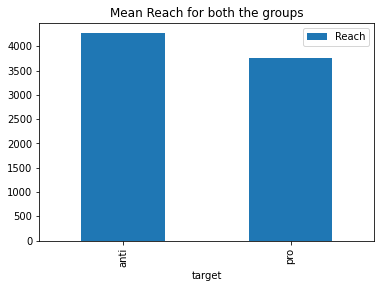

In [41]:
df_full.groupby('target').agg({'Reach':'mean'}).plot(kind='bar')
plt.title("Mean Reach for both the groups")
plt.show()

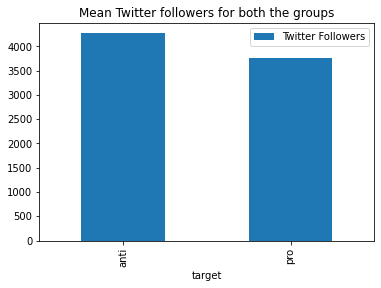

In [42]:
df_full.groupby('target').agg({'Twitter Followers':'mean'}).plot(kind='bar')
plt.title("Mean Twitter followers for both the groups")
plt.show()

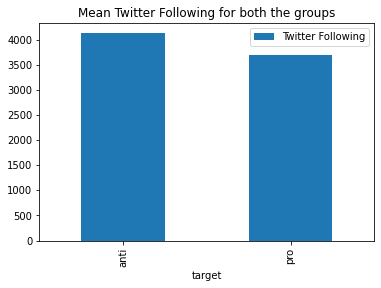

In [43]:
df_full.groupby('target').agg({'Twitter Following':'mean'}).plot(kind='bar')
plt.title("Mean Twitter Following for both the groups")
plt.show()

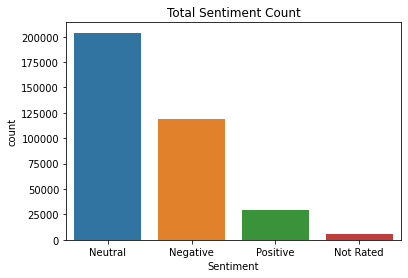

In [44]:
sns.countplot(data=df_full, x="Sentiment").set_title('Total Sentiment Count')
plt.show()

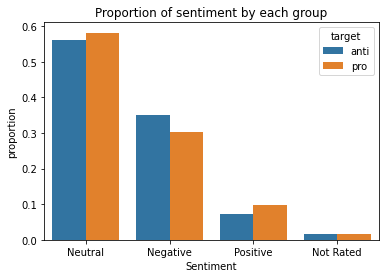

In [45]:
x, y, hue = "Sentiment", "proportion", "target"
(df_full[x]
 .groupby(df_full[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue).set_title('Proportion of sentiment by each group'))
plt.show()

Text(0.5, 1.0, 'Count of tweets by twitter id')

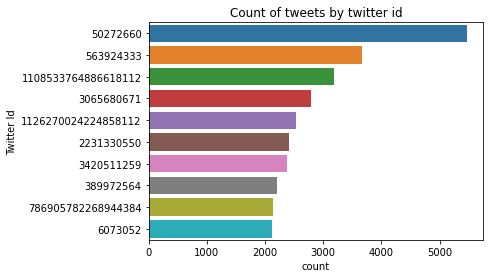

In [46]:
x, y, hue = "day", "proportion", "sex"
hue_order = ["Male", "Female"]
sns.countplot(data=df_full, y="Twitter Id",
             order=df_full['Twitter Id'].value_counts().iloc[:10].index).set_title("Count of tweets by twitter id")

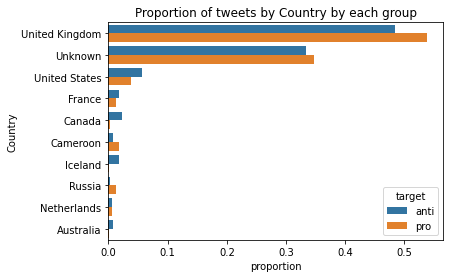

In [47]:
x, y, hue = "Country", "proportion", "target"
(df_full[x]
 .groupby(df_full[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=y, y=x, hue=hue,order=df_full.Country.value_counts().iloc[:10].index).set_title('Proportion of tweets by Country by each group'))
plt.show()

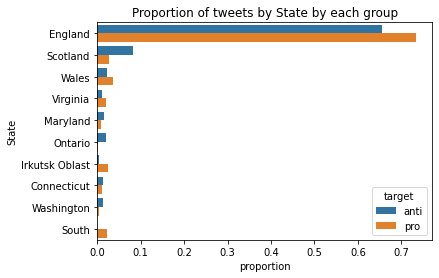

In [48]:
x, y, hue = "State", "proportion", "target"
(df_full[x]
 .groupby(df_full[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=y, y=x, hue=hue,order=df_full.State.value_counts().iloc[:10].index).set_title('Proportion of tweets by State by each group'))
plt.show()

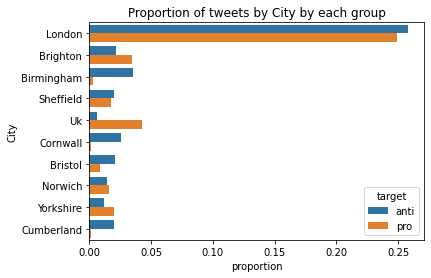

In [49]:
x, y, hue = "City", "proportion", "target"
(df_full[x]
 .groupby(df_full[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=y, y=x, hue=hue,order=df_full.City.value_counts().iloc[:10].index).set_title('Proportion of tweets by City by each group'))
plt.show()

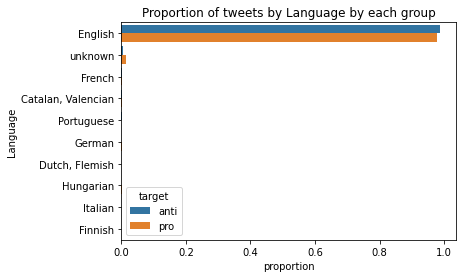

In [50]:
x, y, hue = "Language", "proportion", "target"
(df_full[x]
 .groupby(df_full[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=y, y=x, hue=hue,order=df_full.Language.value_counts().iloc[:10].index).set_title('Proportion of tweets by Language by each group'))
plt.show()

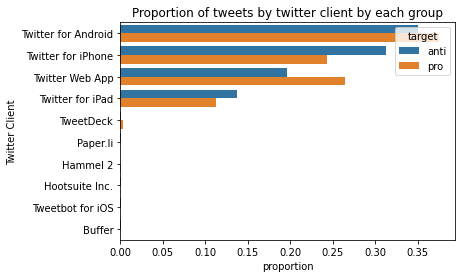

In [51]:
x, y, hue = "Twitter Client", "proportion", "target"
(df_full[x]
 .groupby(df_full[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=y, y=x, hue=hue,order=df_full['Twitter Client'].value_counts().iloc[:10].index).set_title('Proportion of tweets by twitter client by each group'))
plt.show()

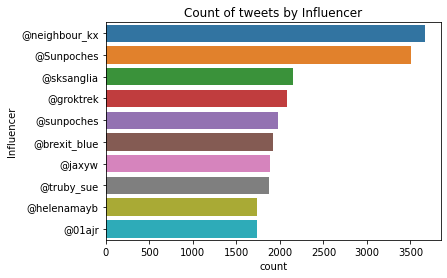

In [52]:
sns.countplot(data=df_full, y="Influencer",
              order=df_full['Influencer'].value_counts().iloc[:10].index).set_title("Count of tweets by Influencer")
plt.show()

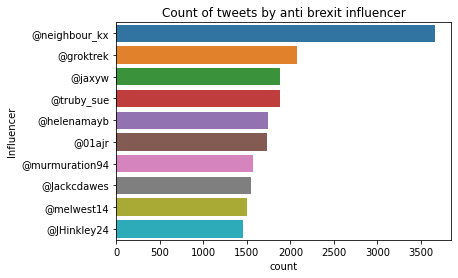

In [53]:
sns.countplot(data=df_full[df_full['target'] == 'anti'], y="Influencer",
              order=df_full[df_full['target'] == 'anti']['Influencer'].value_counts().iloc[:10].index).set_title("Count of tweets by anti brexit influencer")
plt.show()

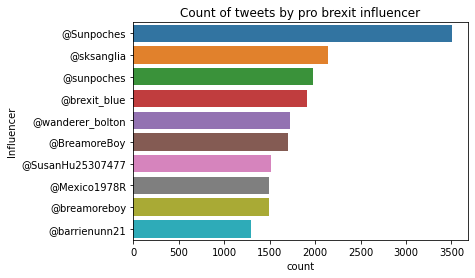

In [54]:
sns.countplot(data=df_full[df_full['target'] == 'pro'], y="Influencer",
              order=df_full[df_full['target'] == 'pro']['Influencer'].value_counts().iloc[:10].index).set_title("Count of tweets by pro brexit influencer")
plt.show()

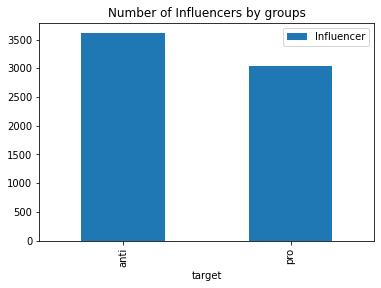

In [55]:

df_full.groupby('target').agg({'Influencer':'nunique'}).plot(kind='bar').set_title("Number of Influencers by groups")
plt.show()

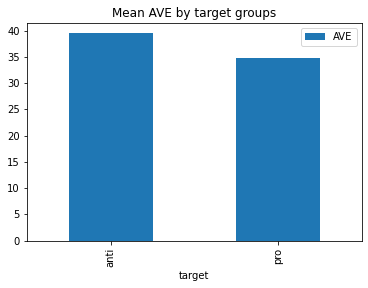

In [56]:
df_full.groupby('target').agg({'AVE':'mean'}).plot(kind='bar').set_title("Mean AVE by target groups")
plt.show()

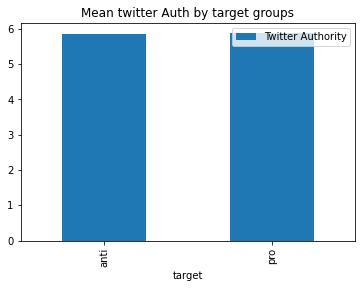

In [57]:
df_full.groupby('target').agg({'Twitter Authority':'mean'}).plot(kind='bar').set_title("Mean twitter Auth by target groups")
plt.show()

In [58]:
df_full['tweet_hour_day'] = pd.to_datetime(df_full['Time']).dt.hour

In [59]:
bins_time = []
for i in tqdm(df_full['tweet_hour_day']):
    if i >= 5 and i < 12:
        bins_time.append("Morning")
    elif i >= 12 and i < 17:
        bins_time.append("Afternoon")
    elif i >= 17 and i < 21:
        bins_time.append("Evening")
    else:
        bins_time.append("Night")
df_full['Parts_of_Day'] = bins_time  

100%|██████████████████████████████| 358205/358205 [00:00<00:00, 2545190.17it/s]


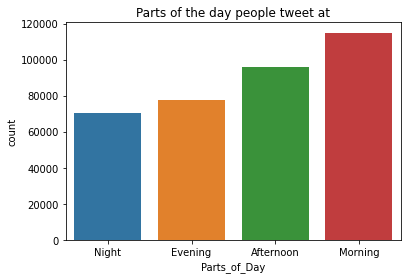

In [60]:
sns.countplot(data=df_full, x="Parts_of_Day").set_title("Parts of the day people tweet at")
plt.show()

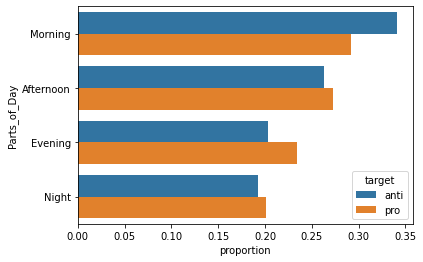

In [61]:
x, y, hue = "Parts_of_Day", "proportion", "target"
(df_full[x]
 .groupby(df_full[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=y, y=x, hue=hue,order=df_full['Parts_of_Day'].value_counts().iloc[:10].index))
plt.show()

In [62]:
check_corr = []
for i in df_full.columns:
    if df_full[i].dtype != 'object':
        check_corr.append(i)

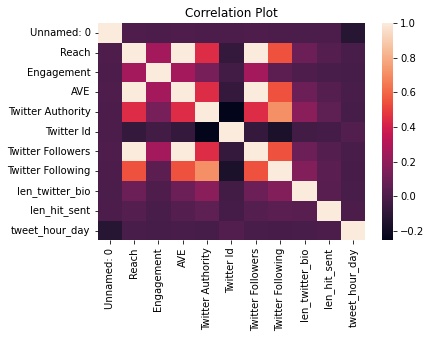

In [63]:
sns.heatmap(df_full[check_corr].corr()).set_title("Correlation Plot")
plt.show()

**Analysis Results**
- Remove columns with high correlation.
- if you see bar plots of reach with target , you can see it follows an identical distribution to twitter followers and AVE.
- Correlation plots confirm this to be true.
- We will drop these columns and get the final dataset.
- We will also remove Date and Alternate date format.
- Tweet ID is all unique so we remove that too.
- Remove Key Phrases and Keywords because they are derived from the hit sentence column.
- Remove twitter screen name,influencer and twitter ID this seems to be a bit redundant as in future there will be new users.
- Remove Engagement column because it has too many null values.

In [64]:
cols_remove = ['Unnamed: 0','AVE','Twitter Followers','Tweet Id','URL','Date',"Key Phrases","Keywords",
               'User Profile Url','Twitter Screen Name','Influencer','Twitter Screen Name','Twitter Id',
              'Engagement']

In [65]:
df_full.drop(cols_remove,inplace=True,axis=1)

In [66]:
df_full

,Hit Sentence,Country,Language,Reach,Sentiment,Twitter Authority,Twitter Client,Twitter Bio,Twitter Following,Alternate Date Format,Time,State,City,target,len_twitter_bio,len_hit_sent,tweet_hour_day,Parts_of_Day
0,ddy sandieshoes value brexit tory mps back con...,Cameroon,English,122,Neutral,4.0,Twitter for Android,veggie burger lover animals nature keen brexit...,185.0,"Jan 15, 2022",11:58 PM,North,NaN,pro,12,26,23,Night
1,ricksacrop michael fabricant absolutely right ...,United Kingdom,English,5721,Negative,7.0,Twitter for Android,proud british animal lover monarchist pro brex...,6291.0,"Jan 15, 2022",11:57 PM,England,NaN,pro,10,22,23,Night
2,stokiedrew find rich tory voters assume unioni...,United Kingdom,English,7219,Negative,7.0,Twitter for Android,british irish ulster scots pul right wing brex...,7433.0,"Jan 15, 2022",11:56 PM,Northern Ireland,Belfast,pro,9,20,23,Night
3,denistmurray brexit britain win london name be...,United Kingdom,English,700,Positive,5.0,Twitter for iPhone,news conservatives brexiteer block ads,1014.0,"Jan 15, 2022",11:54 PM,NaN,NaN,pro,5,13,23,Night
4,afneil johnson take tories likelihood impose r...,United Kingdom,English,200,Neutral,4.0,Twitter for Android,brexiteer shipbuilder plater welder live fish ...,822.0,"Jan 15, 2022",11:53 PM,England,NaN,pro,14,20,23,Night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210569,prfchrispainter johnson delay dither pandemic ...,Unknown,English,6011,Negative,7.0,Twitter for Android,languages literature europe remainer pic fbpa,6178.0,"Mar 27, 2022",12:04 AM,NaN,NaN,anti,6,31,0,Night
210570,kennedy bizarrely brexit irish person live bri...,United Kingdom,English,2753,Neutral,6.0,Twitter for Android,fbpe fbppr remainer ever engage citizen ordina...,2337.0,"Mar 27, 2022",12:04 AM,England,Milton Keynes,anti,12,19,0,Night
210571,sillyshib brexit suppose split apart instead g...,United Kingdom,English,2753,Neutral,6.0,Twitter for Android,fbpe fbppr remainer ever engage citizen ordina...,2337.0,"Mar 27, 2022",12:03 AM,England,Milton Keynes,anti,12,14,0,Night
210572,mitsyarty brexit go well term industry drop ex...,United Kingdom,English,1380,Positive,6.0,Twitter for iPhone,fbpe fbppr centrist fantasist remainer anti br...,2298.0,"Mar 27, 2022",12:01 AM,England,London,anti,8,22,0,Night


In [67]:
# df_full.to_csv("Cleaned_data.csv",index=False)

# Clustering

In [89]:
#Read Cleaned Data
df_cleaned = pd.read_csv('Cleaned_data.csv')
df_cleaned = df_cleaned.dropna()
df_cleaned.reset_index(inplace=True,drop=True)

In [91]:
df_cleaned.to_csv("Cleaned_Data.csv",index=False)

In [69]:
df_pro = df_cleaned[df_cleaned['target'] == 'pro'][:10000]
df_anti = df_cleaned[df_cleaned['target'] == 'anti'][:10000]
df_cluster = df_pro.append(df_anti)
df_cluster.reset_index(inplace=True,drop=True)

In [70]:
df_cluster['target'].value_counts()

pro     10000
anti    10000
Name: target, dtype: int64

In [71]:
df_cluster['Sentiment'].value_counts()

Neutral      11655
Negative      6473
Positive      1682
Not Rated      190
Name: Sentiment, dtype: int64

In [72]:
target_map = {
    'pro':1,
    'anti':0
}

sentiment_map = {
    'Neutral':0,
    'Negative':1,
    'Positive':2,
    "Not Rated":3
}
df_cluster['target']= df_cluster['target'].map(target_map)
df_cluster['Sentiment']= df_cluster['Sentiment'].map(sentiment_map)

In [73]:
#TFIDF WORD FEATURES
word_vectorizer = TfidfVectorizer(stop_words = 'english')
word_vectorizer.fit(df_cluster['Hit Sentence'])
train_word_features = word_vectorizer.transform(df_cluster['Hit Sentence'])

In [74]:
train_word_features

<20000x21415 sparse matrix of type '<class 'numpy.float64'>'
	with 348547 stored elements in Compressed Sparse Row format>

Text(0.5, 1.0, 'Clustering with target variable')

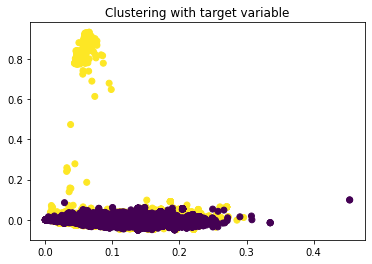

In [81]:
#USING SVD TO PLOT IN 2D
svd = TruncatedSVD(n_components=2).fit_transform(train_word_features)
plt.scatter(svd[:,0], svd[:,1], c=df_cluster['target'])
plt.title("Clustering with target variable")

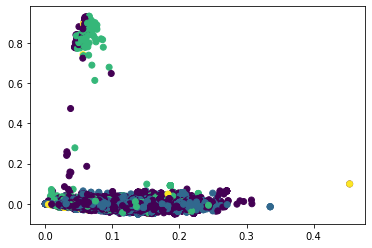

In [82]:
plt.scatter(svd[:,0], svd[:,1], c=df_cluster['Sentiment'])

In [83]:
#eblow method kmeans
error = [] 
for i in range(1, 15): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(train_word_features) 
    error.append(kmeans.inertia_)

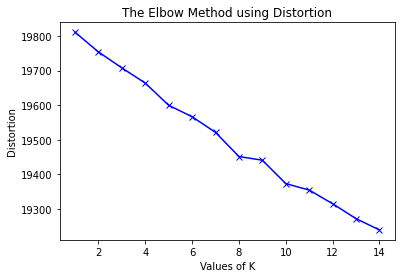

In [84]:
plt.plot([i for i in range(1,15)], error, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

**KMEANS**

Text(0.5, 1.0, 'For K = 2')

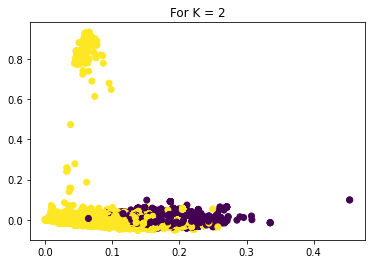

In [85]:

kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
labels_kmeans = kmeans.fit_predict(train_word_features) 
plt.scatter(svd[:,0], svd[:,1], c=labels_kmeans)
plt.title("For K = 2")

Text(0.5, 1.0, 'For K = 3')

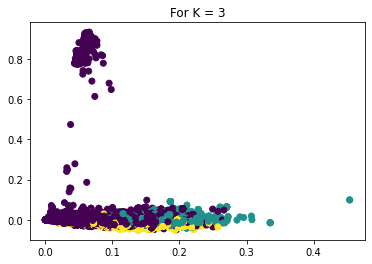

In [86]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
labels_kmeans = kmeans.fit_predict(train_word_features) 
plt.scatter(svd[:,0], svd[:,1], c=labels_kmeans)
plt.title("For K = 3")

Text(0.5, 1.0, 'For K = 4')

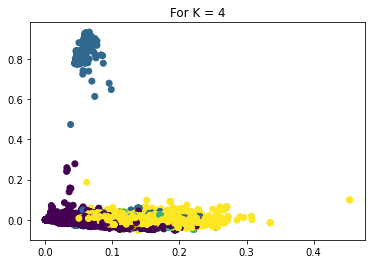

In [87]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
labels_kmeans = kmeans.fit_predict(train_word_features) 
plt.scatter(svd[:,0], svd[:,1], c=labels_kmeans)
plt.title("For K = 4")

**DBSCAN**

In [88]:
dbsc = DBSCAN(n_jobs=-1,min_samples=40,eps=0.7,algorithm="kd_tree")
db_labels = dbsc.fit_predict(train_word_features)
print("The clusters Predicted are")
Counter(db_labels)

/Users/crazyk/opt/anaconda3/envs/test/lib/python3.8/site-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


The clusters Predicted are


Counter({-1: 19417,
         1: 44,
         0: 110,
         2: 51,
         3: 57,
         4: 50,
         5: 41,
         6: 45,
         7: 40,
         8: 41,
         9: 58,
         10: 46})

Text(0.5, 1.0, 'DBScan Clusters')

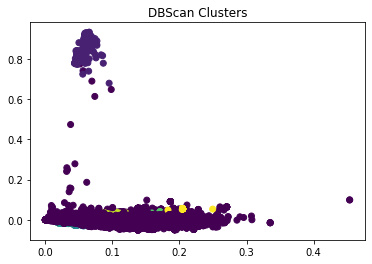

In [89]:
plt.scatter(svd[:,0], svd[:,1], c=db_labels)
plt.title("DBScan Clusters")

**Hierarchical Clustering**

In [90]:
svd_hi = TruncatedSVD(n_components=10).fit_transform(train_word_features)

Text(0.5, 1.0, 'Hierarchical Clustering with Euclidean')

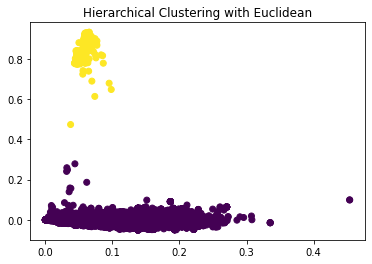

In [91]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='average')  
clusters = cluster.fit_predict(svd_hi)
plt.scatter(svd[:,0], svd[:,1], c=clusters)
plt.title("Hierarchical Clustering with Euclidean")

Text(0.5, 1.0, 'Hierarchical Clustering with Manhattan')

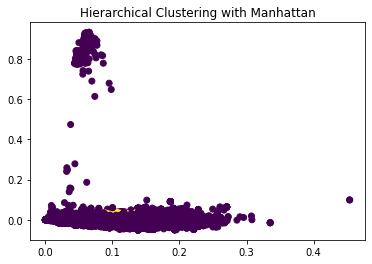

In [92]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='manhattan', linkage='average')  
clusters = cluster.fit_predict(svd_hi)
plt.scatter(svd[:,0], svd[:,1], c=clusters)
plt.title("Hierarchical Clustering with Manhattan")

Text(0.5, 1.0, 'Hierarchical Clustering with cosine')

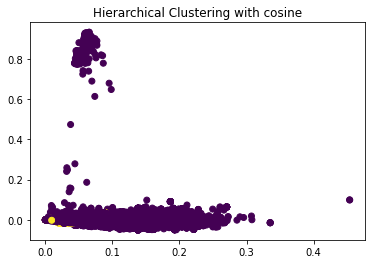

In [93]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='cosine', linkage='average')  
clusters = cluster.fit_predict(svd_hi)
plt.scatter(svd[:,0], svd[:,1], c=clusters)
plt.title("Hierarchical Clustering with cosine")

In [80]:
#split test and train
X_train, X_test, y_train, y_test = train_test_split(df_cluster.drop('target',axis=1), 
                                                    df_cluster['target'], test_size=0.15, 
                                                    random_state=42,stratify=df_cluster['target'])

In [81]:
#create word vectors
word_vectorizer = TfidfVectorizer(stop_words = 'english')
word_vectorizer.fit(X_train['Hit Sentence'])
train_word_features = word_vectorizer.transform(X_train['Hit Sentence'])
test_word_feature = word_vectorizer.transform(X_test['Hit Sentence'])

word_vectorizer = CountVectorizer(stop_words = 'english')
word_vectorizer.fit(X_train['Hit Sentence'])
train_word_features_cvec = word_vectorizer.transform(X_train['Hit Sentence'])
test_word_feature_cvec = word_vectorizer.transform(X_test['Hit Sentence'])

In [122]:
test_word_feature

<3000x19913 sparse matrix of type '<class 'numpy.float64'>'
	with 50635 stored elements in Compressed Sparse Row format>

In [123]:
train_word_features

<17000x19913 sparse matrix of type '<class 'numpy.float64'>'
	with 296331 stored elements in Compressed Sparse Row format>

## Decision Trees

In [114]:

dt = DecisionTreeClassifier(criterion="gini")
dt.fit(train_word_features,y_train)
preds_test = dt.predict(test_word_feature)
preds_train = dt.predict(train_word_features)
print(f"F1score for test set is with criteria as gini :{f1_score(y_pred=preds_test,y_true=y_test)}")

F1score for test set is with criteria as gini :0.8566587597424601


[Text(0.5, 1.0, 'Decision Tree With Gini')]

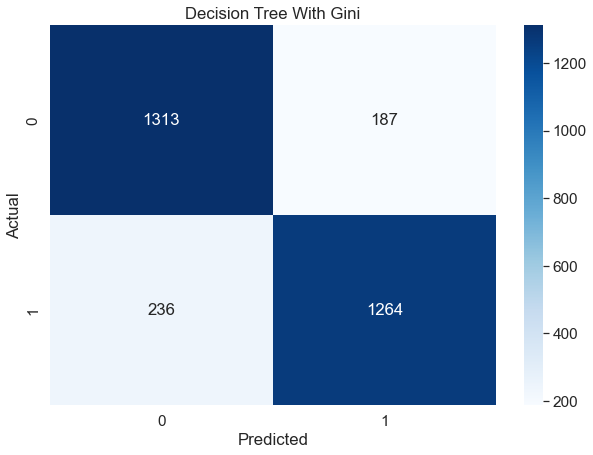

In [115]:
data = confusion_matrix(y_test, preds_test)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,fmt='g').set(title='Decision Tree With Gini')

In [116]:
dt = DecisionTreeClassifier(criterion="entropy")
dt.fit(train_word_features,y_train)
preds_test = dt.predict(test_word_feature)
preds_train = dt.predict(train_word_features)
print(f"F1score for test set is with criteria as entropy :{f1_score(y_pred=preds_test,y_true=y_test)}")

F1score for test set is with criteria as entropy :0.851465139777703


[Text(0.5, 1.0, 'Decision Tree With Entropy')]

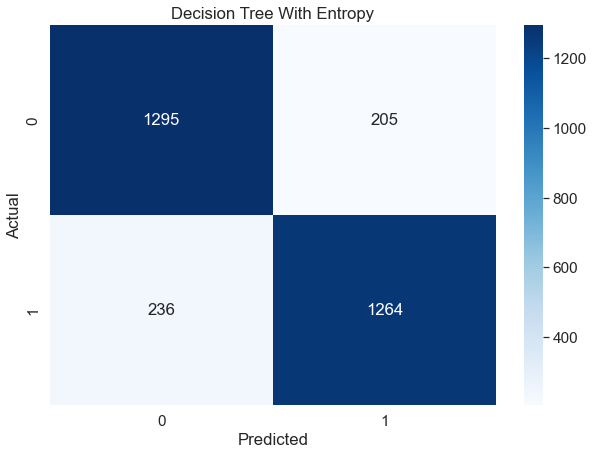

In [117]:
data = confusion_matrix(y_test, preds_test)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,fmt='g').set(title='Decision Tree With Entropy')# font size


## NAIVE BAYES

In [118]:
nb = MultinomialNB()
nb.fit(train_word_features,y_train)
preds_test =nb.predict(test_word_feature)
preds_train =nb.predict(train_word_features)
print(f"F1score for test set is :{f1_score(y_pred=preds_test,y_true=y_test)}")

F1score for test set is :0.8983957219251337


[Text(0.5, 1.0, 'Naive Bayes')]

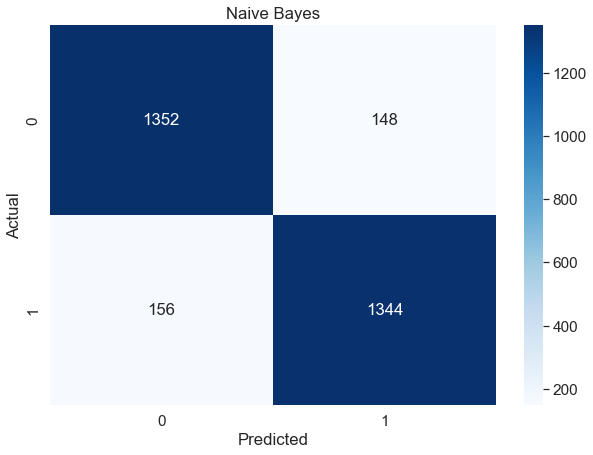

In [119]:
data = confusion_matrix(y_test, preds_test)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,fmt='g').set(title='Naive Bayes')# font size


## SVM

In [87]:
nb = SVC()
nb.fit(train_word_features,y_train)
preds_test =nb.predict(test_word_feature)
preds_train =nb.predict(train_word_features)
print(f"F1score for test set is :{f1_score(y_pred=preds_test,y_true=y_test)}")

F1score for test set is :0.9158069883527453


[Text(0.5, 1.0, 'Rbf and C=1.0')]

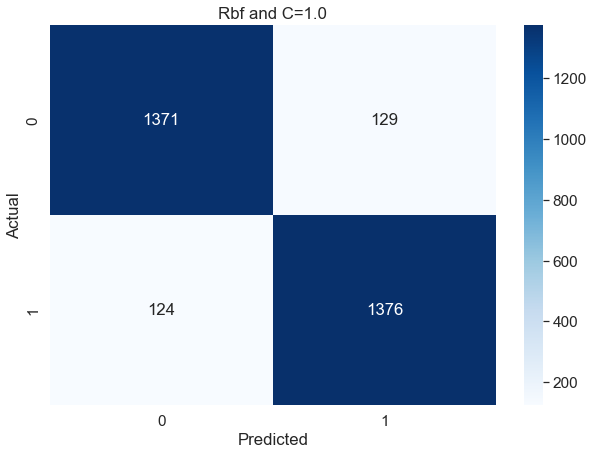

In [100]:
data = confusion_matrix(y_test, preds_test)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,fmt='g').set(title='Rbf and C=1.0')# font size


In [101]:
nb = SVC(kernel="poly",C=0.8)
nb.fit(train_word_features,y_train)
preds_test =nb.predict(test_word_feature)
preds_train =nb.predict(train_word_features)
print(f"F1score for test set is :{f1_score(y_pred=preds_test,y_true=y_test)}")

F1score for test set is :0.8428899082568807


[Text(0.5, 1.0, 'Poly and C=0.8')]

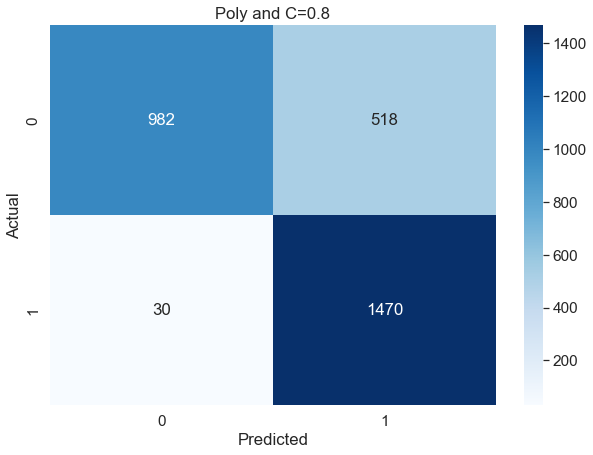

In [102]:
data = confusion_matrix(y_test, preds_test)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,fmt='g').set(title='Poly and C=0.8')

In [120]:
nb = SVC(kernel="linear",C=1.4)
nb.fit(train_word_features,y_train)
preds_test =nb.predict(test_word_feature)
preds_train =nb.predict(train_word_features)
print(f"F1score for test set is :{f1_score(y_pred=preds_test,y_true=y_test)}")

F1score for test set is :0.911170928667564


[Text(0.5, 1.0, 'Linear and C=1.4')]

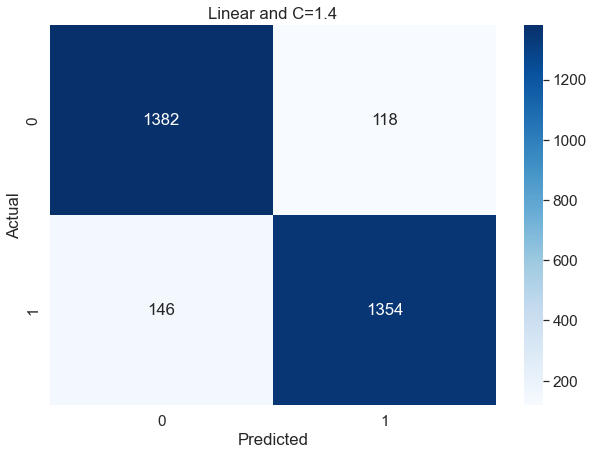

In [121]:
data = confusion_matrix(y_test, preds_test)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,fmt='g').set(title='Linear and C=1.4')